In [47]:
import numpy as np
import matplotlib.pyplot as plt

# high quality plots
plt.rcParams['figure.dpi'] = 300

#### **Auto-associative networks and pattern completion**

#### 1. Creating the Hebbian Matrix

Implement a network with 10 neurons in an input and output layer, using input vectors distributed and normalized as in the lab for Week 3. Create an outer product matrix to realize two "auto-associations" - that is, when presented with an activity pattern on the input layer, the network should re-generate the same pattern in the output layer.

First, let's create a function to generate the Hebbian system and another function to recall the output pattern from the Hebbian system — these functions will be used throughout the assignment. 

In [48]:
# function to create a Hebbian system of some size
def createHebbianSystem(N, M, eta = 1): 
    """
    Generate a Hebbian system with M associations, where each association
    consists of an N-dimensional input pattern and an N-dimensional output pattern.
    
    Parameters:
      N (int): Number of neurons (dimension of each vector)
      M (int): Number of associations (patterns)
      eta (float): Learning rate
      
    Returns:
      x (ndarray): Input patterns, shape (N, M)
      y (ndarray): Output patterns, shape (N, M)
      A (ndarray): Aggregate Hebbian matrix, shape (N, N), computed as
                   A = sum_{i=0}^{M-1} eta * outer( y[:, i], x[:, i] )
    """

    # initialize input and output vectors
    x = np.zeros( (N,M) )
    y = np.zeros( (N,M) )

    for ii in range(M):
        # Generate random pattern in [-1, 1] and normalize
        x[:,ii] = 2 * ( np.random.rand( N ) - 0.5 )
        x[:,ii] = x[:,ii] / np.linalg.norm( x[:,ii] )
        y[:,ii] = 2 * ( np.random.rand( N ) - 0.5 )
        y[:,ii] = y[:,ii] / np.linalg.norm( y[:,ii] )
    
    # generate the aggregate Hebbian outer product matrix
    A = np.zeros((N, N))
    for ii in range(M):
        A += eta * np.outer(y[:, ii], x[:, ii])

    return x, y, A

# function to recall the output pattern from a given Hebbian system
def recallPattern(A, x_input, degradation_degree = 0, num_patterns_to_degrade = 1): 
    """
    Recall the output pattern from the Hebbian system.

    Parameters:
        A (ndarray): Hebbian matrix, shape (N, N)
        x_input (ndarray): Input pattern(s) matrix, shape (N, M)
        degradation (int): Number of random zero-values to set in the input pattern
    
    Returns:
        y_prime (ndarray): Output pattern(s) matrix, shape (N, M)
    """

    M = len(x_input[0,:])
    N = len(x_input[:,0])

    # error handling (cant degrade more than the number of neurons or patterns in the input matrix)
    if degradation_degree > N or num_patterns_to_degrade > M: 
        raise ValueError("Degradation degree or number of patterns to degrade is greater than the number of neurons or patterns in the input matrix")

    x = np.copy(x_input)

    # degrade the input pattern if degradation is non-zero
    if degradation_degree > 0: 

        for ii in range(num_patterns_to_degrade): 
            # Get random indices to set to zero
            indices = np.random.choice(len(x_input[:,ii]), size=degradation_degree, replace=False)
            x[indices,ii] = 0

    # compute the output pattern y' for each of the M associations
    y_prime = np.zeros( (N,M) )
    for ii in range(M): 
        y_prime[:,ii] = A @ x[:, ii]

    return y_prime

In [49]:
# test the functions without degradation

N = 10
M = 2
eta = 1

# create a Hebbian system
x, y, A = createHebbianSystem(N, M, eta)

# recall the output pattern
y_prime = recallPattern(A, x)

# compute the error by computing the dot product 
for ii in range(M): 
    # print(np.dot(y[:,ii], y_prime[:,ii]))
    print(np.abs( y[:,ii].T @ y_prime[:,ii] ))

1.0609116221722148
1.0609116221722146


We will want to compute the mean similarity between the output pattern and the original pattern for each of the M associations, so the following function will be useful:

In [50]:
def computeMeanError(A, x, y, y_prime):

    """
    Computes the mean error between all of the associations in the Hebbian system.
    """

    M = len(x[0,:])

    # initialize the error vector
    errors = np.zeros(M)

    # compute the error for each of the M associations
    for ii in range(M):
        errors[ii] = np.abs( y[:,ii].T @ y_prime[:,ii] )

    # return the mean error
    return np.mean(errors)

We can create a large of these systems and compute the mean error between the associations 
and report the mean error to assess the performance of the Hebbian system

In [51]:
# create a large number of Hebbian systems
num_systems = 10000
non_degraded_errors = np.zeros(num_systems)

for ii in range(num_systems): 
    x, y, A = createHebbianSystem(N, M, eta)
    y_prime = recallPattern(A, x)
    non_degraded_errors[ii] = computeMeanError(A, x, y, y_prime)

# compute the mean error
mean_error = np.mean(non_degraded_errors)
print(mean_error)

0.999602520666988


As is evident from the above code, the Hebbian system is able to recall the output pattern with a high degree of accuracy. Now we can move on and test pattern completion in the Hebbian system.

#### **2. (N = 10) Testing pattern completion by passing degraded inputs**

Next, investigate pattern completion in this network. Take one of the stored patterns and create a degraded version by setting one or two elements of the input vector to zero. Attempt to retrieve the original patterns using these degraded inputs. Quantify how well the network reconstructs the original patterns. What changes when two elements are set to zero instead of one?

##### **2.1 Degrading 1 element (of each input pattern)**

In [52]:
# create the system 
N = 10; M = 2; eta = 1
x, y, A = createHebbianSystem(N, M, eta)

# recall the output pattern with degradation of the input
y_prime = recallPattern(A, x, degradation_degree=1, num_patterns_to_degrade=M)

# initialize the error vector 
error = np.zeros(M)

# compute the error for each of the M associations
for ii in range(M): 
    error[ii] = np.abs( y[:,ii].T @ y_prime[:,ii] )

print(error)

[0.72796837 0.72087654]


Running the above code a few times, we can see that the overlap between the original and the degraded pattern tends to be lower than the overlap between the original and the un-degraded pattern. However, to really assess if there's a difference, we can compute the respective overlaps for a large number of degraded patterns and compare.


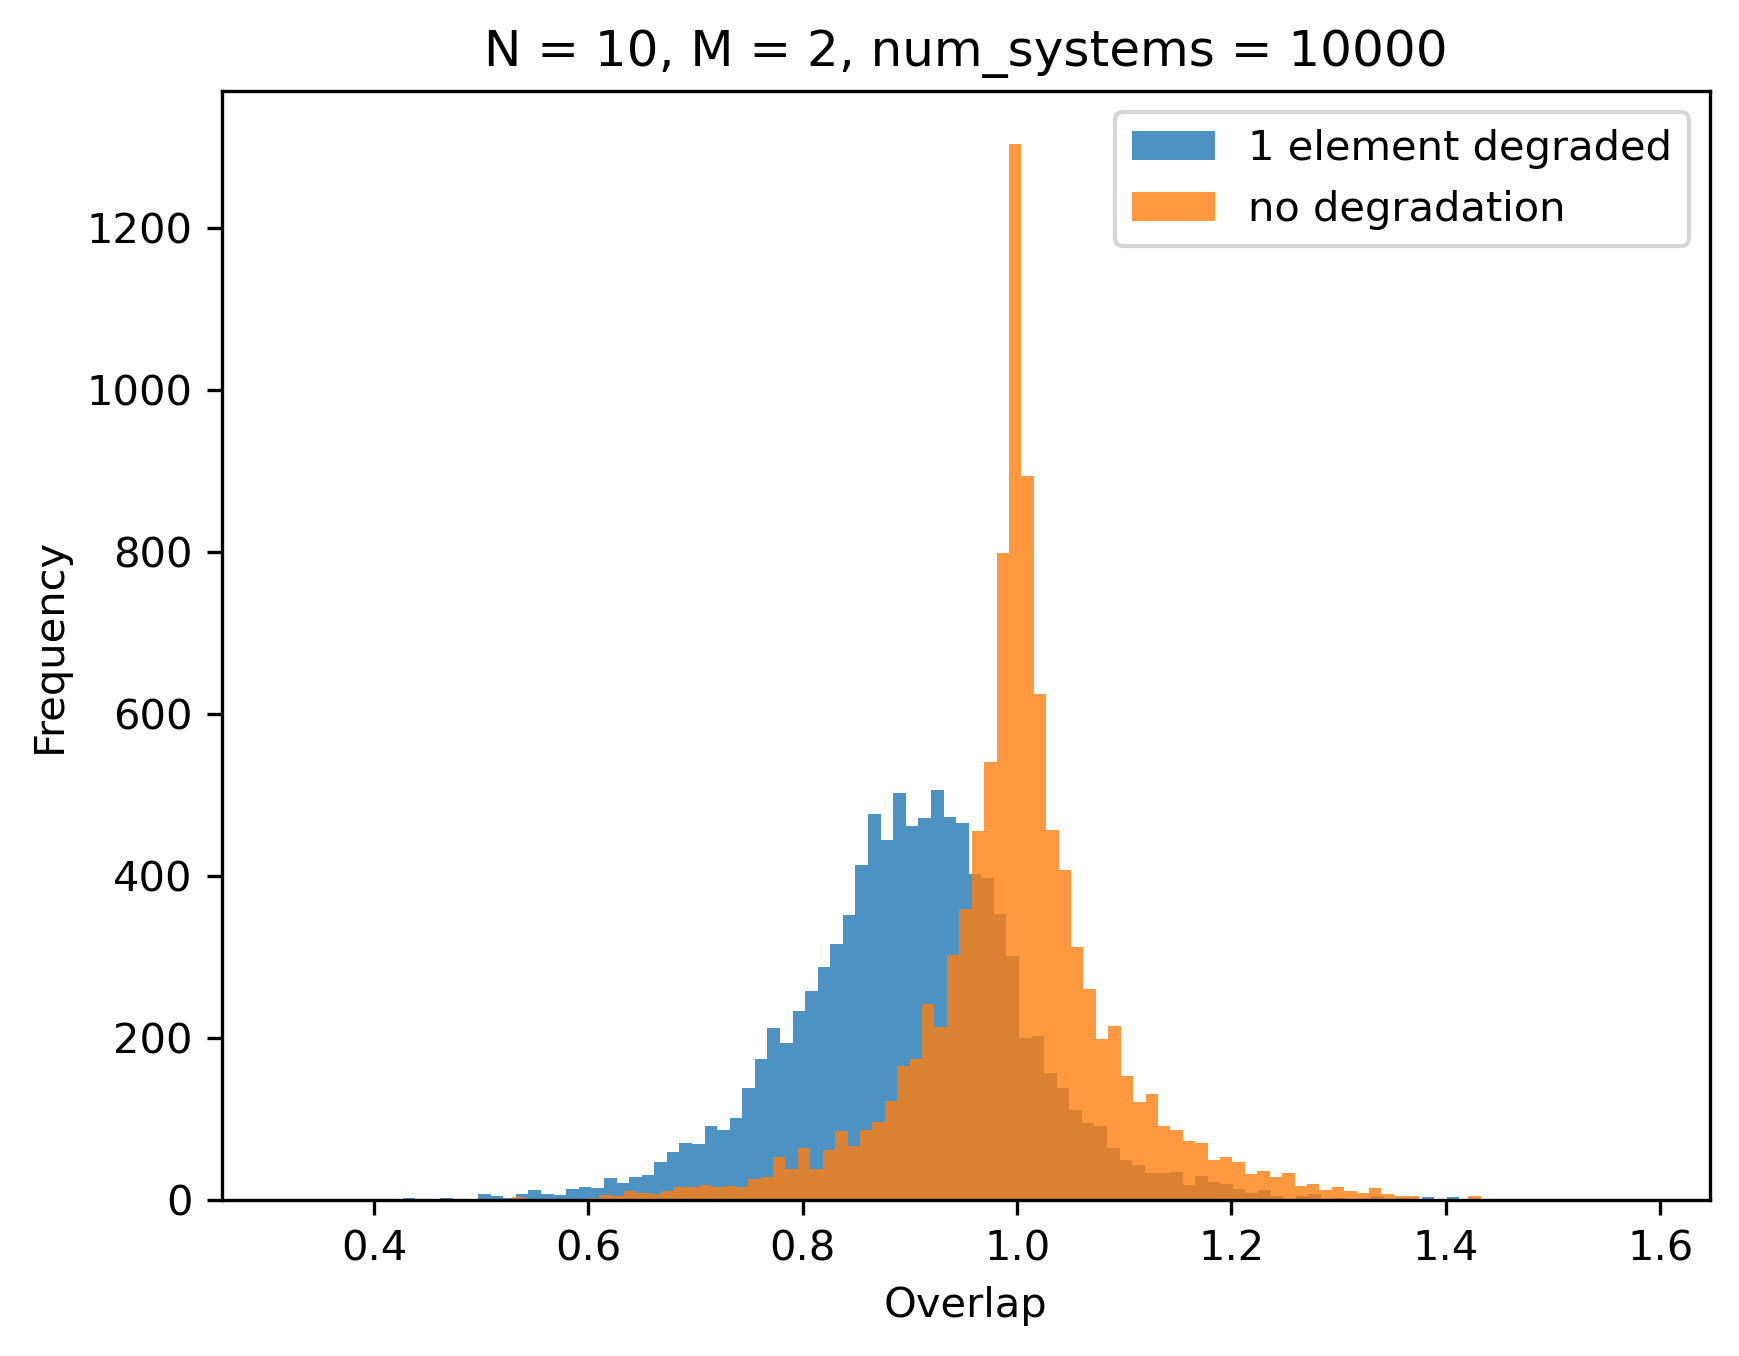

In [67]:
num_systems = 10000
degraded_errors = np.zeros(num_systems)

for ii in range(num_systems): 
    x, y, A = createHebbianSystem(N, M, eta)
    y_prime = recallPattern(A, x, degradation_degree=1, num_patterns_to_degrade=M)
    degraded_errors[ii] = computeMeanError(A, x, y, y_prime) 

plt.hist(degraded_errors, label='1 element degraded', alpha=0.8, bins = 100)
plt.hist(non_degraded_errors, label='no degradation', alpha=0.8, bins = 100)
plt.legend()
plt.xlabel('Overlap')
plt.ylabel('Frequency')
plt.title(f"N = {N}, M = {M}, num_systems = {num_systems}")
plt.show()

Observe that the degraded patterns have a lower overlap with the original patterns compared to the non-degraded patterns. There is a clear separation between the two distributions — this is exactly what we expect.


##### **2.2 Degrading 2 elements (of one input pattern)**

Now let's do the same but for 2 elements of each input pattern.

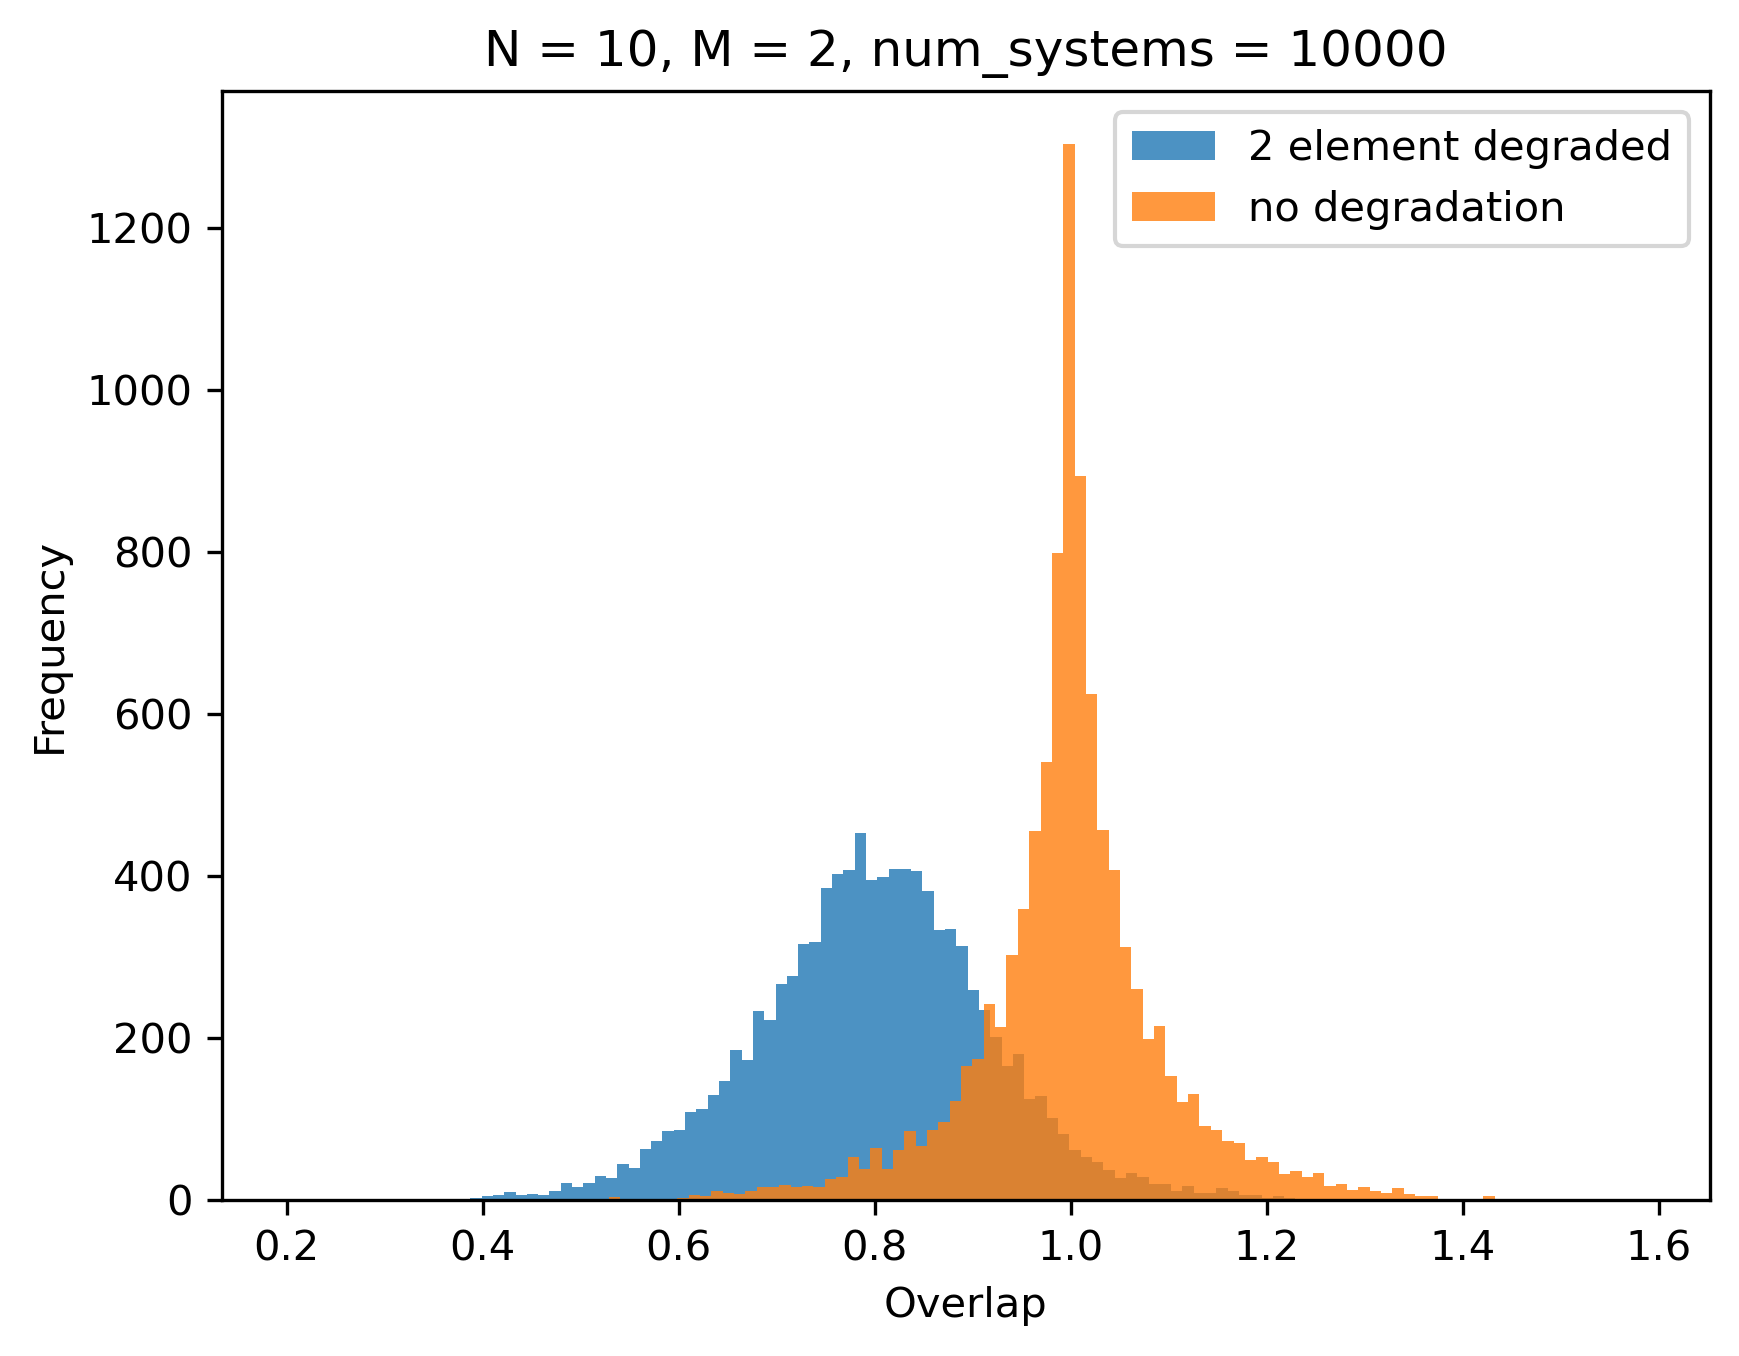

In [ ]:
num_systems = 10000
two_degraded_errors = np.zeros(num_systems)

for ii in range(num_systems): 
    x, y, A = createHebbianSystem(N, M, eta)
    y_prime = recallPattern(A, x, degradation_degree=2, num_patterns_to_degrade=M)
    two_degraded_errors[ii] = computeMeanError(A, x, y, y_prime) 

plt.hist(two_degraded_errors, label='2 elements degraded', alpha=0.8, bins = 100)
plt.hist(non_degraded_errors, label='no degradation', alpha=0.8, bins = 100)
plt.legend()
plt.xlabel('Overlap')
plt.ylabel('Frequency')
plt.title(f"N = {N}, M = {M}, num_systems = {num_systems}")
plt.show()

Observe that now the mean overlap is even lower for the degraded simulations. The two distributions are more separated now.

#### **3. (N = 20) Testing pattern completion by passing degraded inputs**

Now let's do the same as the above for a network with 20 neurons. We will compare the performance of the network with the performance of the network with 10 neurons (both with no degradation and with 1 and 2 elements degraded).

##### **3.1 Degrading 1 element (of each input pattern)**

In [75]:
# first compute the errors for 20 neurons with no degradation
N = 20
M = 2
eta = 1

non_degraded_errors_N20 = np.zeros(num_systems)

for ii in range(num_systems):
    x, y, A = createHebbianSystem(N, M, eta)
    y_prime = recallPattern(A, x)
    non_degraded_errors_N20[ii] = computeMeanError(A, x, y, y_prime)

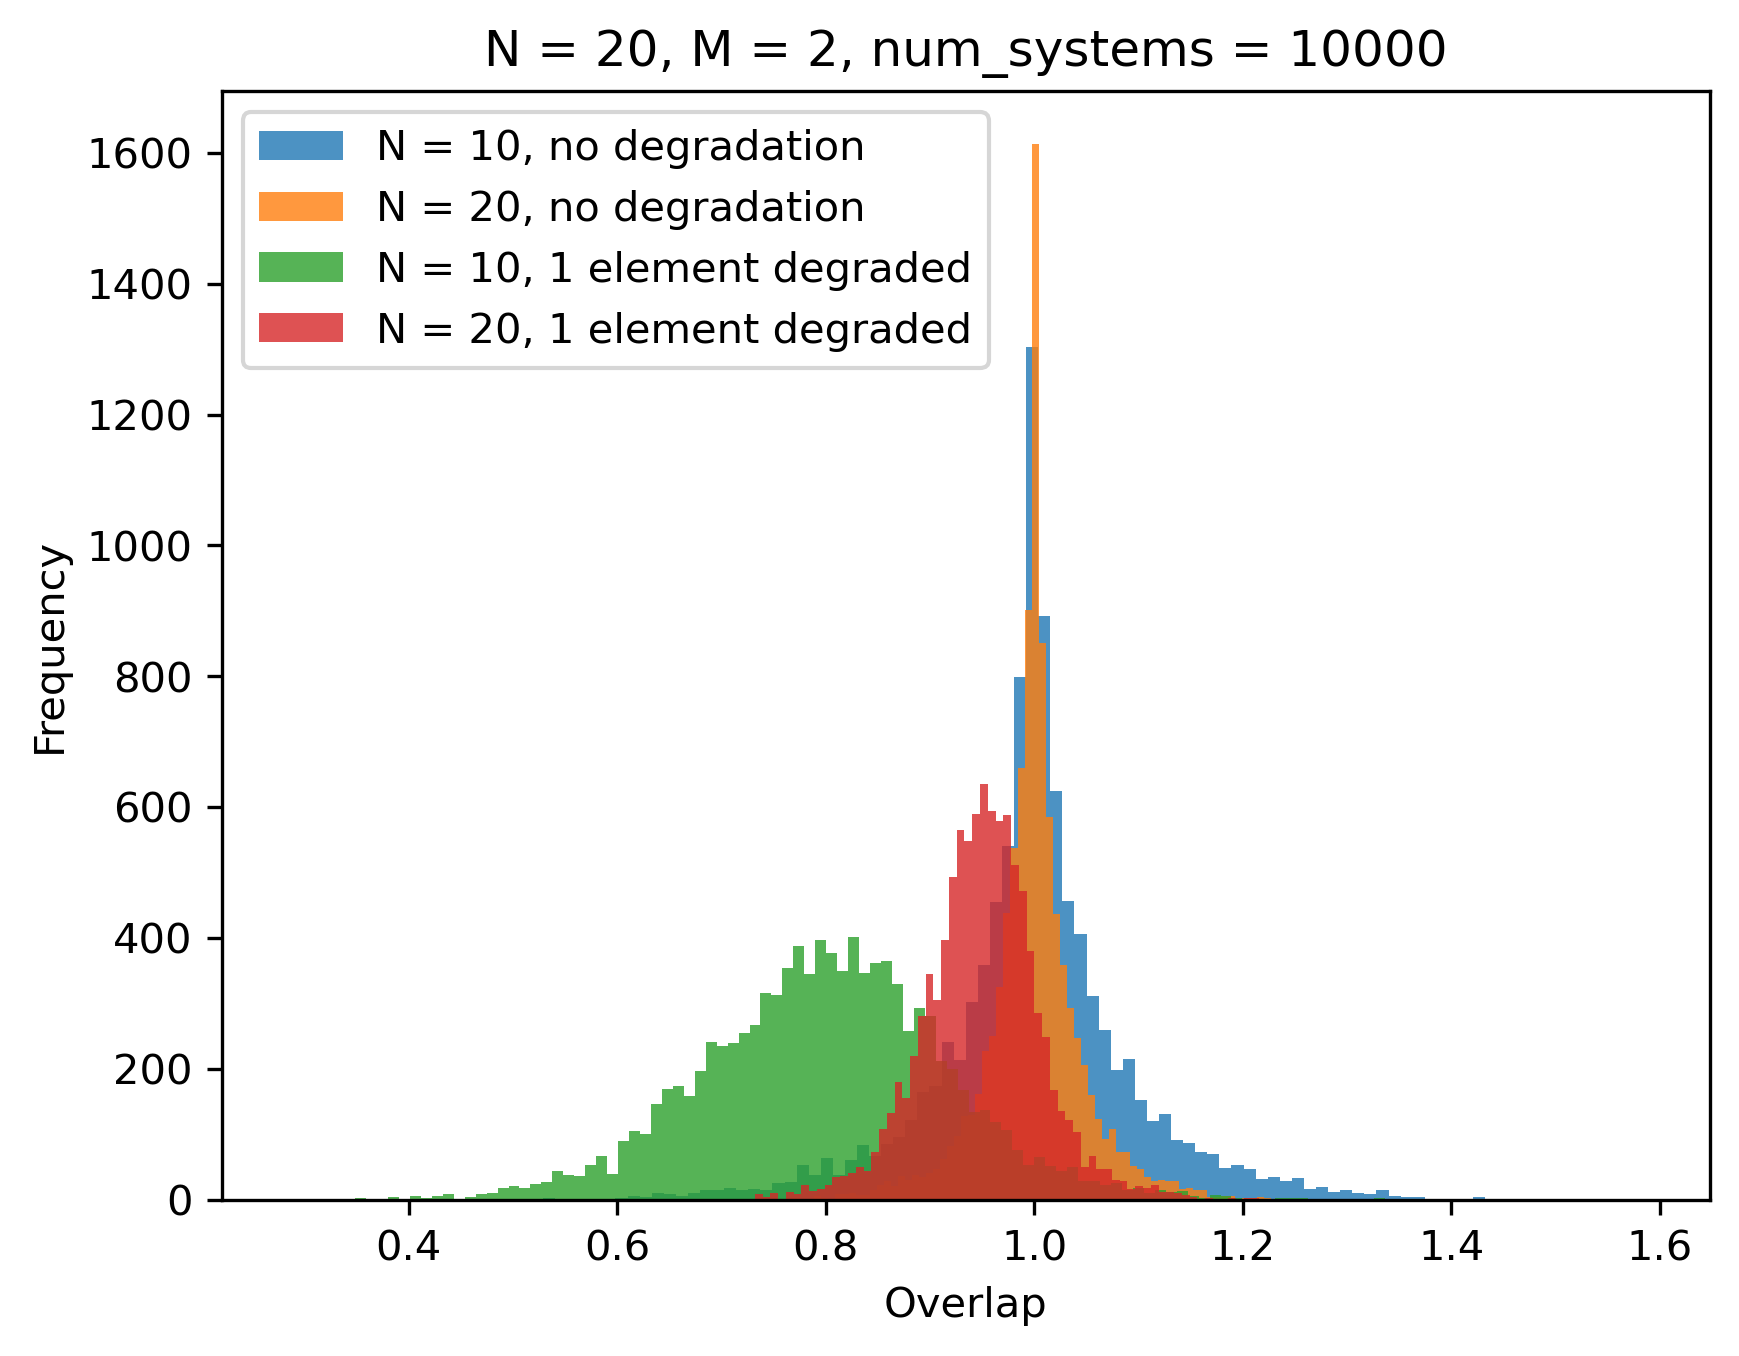

In [77]:
N = 20
M = 2
eta = 1

degraded_errors_N20 = np.zeros(num_systems)

for ii in range(num_systems):
    x, y, A = createHebbianSystem(N, M, eta)
    y_prime = recallPattern(A, x, degradation_degree=1, num_patterns_to_degrade=M)
    degraded_errors_N20[ii] = computeMeanError(A, x, y, y_prime)
    
# plot the non-degraded systems for N = 10 and N = 20
plt.hist(non_degraded_errors, label='N = 10, no degradation', alpha=0.8, bins = 100)
plt.hist(non_degraded_errors_N20, label='N = 20, no degradation', alpha=0.8, bins = 100)

# plot the degraded systems for N = 10 and N = 20
plt.hist(degraded_errors, label='N = 10, 1 element degraded', alpha=0.8, bins = 100)
plt.hist(degraded_errors_N20, label='N = 20, 1 element degraded', alpha=0.8, bins = 100)

plt.legend()
plt.xlabel('Overlap')
plt.ylabel('Frequency')
plt.title(f"N = {N}, M = {M}, num_systems = {num_systems}")
plt.show()

Observe that the degraded system is much more resiliant to degradation for N = 20 than for N = 10 — as seen by the greated overlap of the degraded systems for N = 20. It is much closer to the non-degraded systems' distributions.

Text(0, 0.5, 'Frequency')

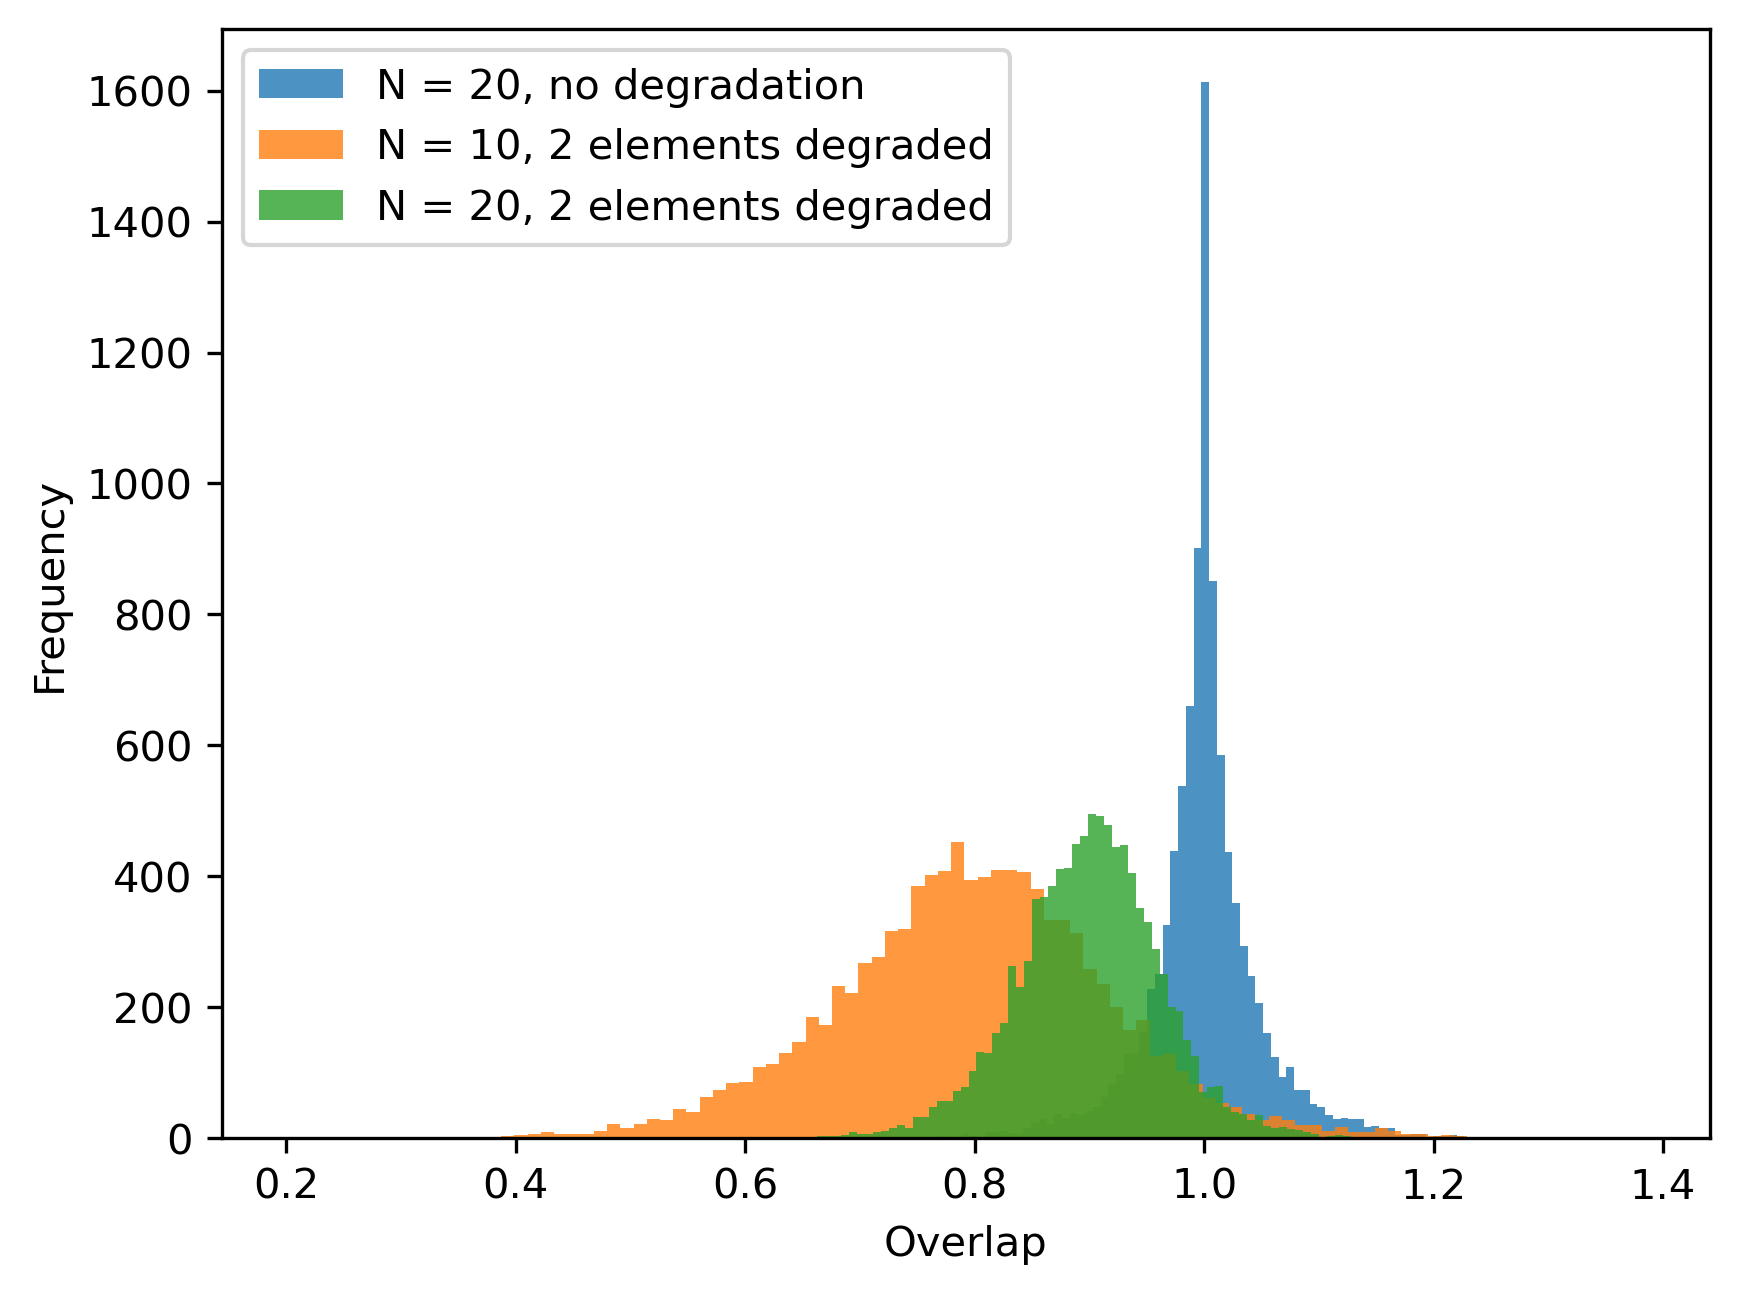

In [80]:
N = 20
M = 2
eta = 1

two_degraded_errors_N20 = np.zeros(num_systems)

for ii in range(num_systems):
    x, y, A = createHebbianSystem(N, M, eta)
    y_prime = recallPattern(A, x, degradation_degree=2, num_patterns_to_degrade=M)
    two_degraded_errors_N20[ii] = computeMeanError(A, x, y, y_prime)
    
# plot the non-degraded systems for N = 20
plt.hist(non_degraded_errors_N20, label='N = 20, no degradation', alpha=0.8, bins = 100)

plt.hist(two_degraded_errors, label='N = 10, 2 elements degraded', alpha=0.8, bins = 100)
plt.hist(two_degraded_errors_N20, label='N = 20, 2 elements degraded', alpha=0.8, bins = 100)

plt.legend()
plt.xlabel('Overlap')
plt.ylabel('Frequency')

As expected, the N = 20 network is much more resiliant to 2 degraded elements than the N = 10 network. 

After these tests, we can conclude that the N = 20 network is much better at pattern completion than the N = 10 network. This likely points to the fact that a networks ability to pattern complete is related to the number of neurons in the network, and in general, improves with the number of neurons.